In [313]:
import json
import cv2
import numpy as np

from dataclasses import dataclass

from PIL import Image
from IPython import display

import os
import shutil

from typing import Optional
from __future__ import annotations

In [314]:
@dataclass
class Joint:
    parent: Optional[Joint]
    x: float
    y: float
    confidence: float
    
    def is_empty(self):
        return self.x == 0 and self.y == 0 and self.confidence == 0

In [315]:
joint_colours = np.linspace(0, 179, 26)[:-1]
joint_colours = np.array([(round(h), 255, 255) for h in joint_colours]).astype(np.uint8)
joint_colours = joint_colours[np.newaxis, ...]
joint_colours = cv2.cvtColor(joint_colours, cv2.COLOR_HSV2BGR)
joint_colours = joint_colours.squeeze().astype(int)
joint_colours = [tuple([int(x) for x in joint_colour]) for joint_colour in joint_colours]

In [316]:
joint_connections = {
    "nose": None,
    "neck": "nose",
    "right_shoulder": "neck",
    "right_elbow": "right_shoulder",
    "right_wrist": "right_elbow",
    "left_shoulder": "neck",
    "left_elbow": "left_shoulder",
    "left_wrist": "left_elbow",
    "mid_hip": "neck",
    "right_hip": "mid_hip",
    "right_knee": "right_hip",
    "right_ankle": "right_knee",
    "left_hip": "mid_hip",
    "left_knee": "left_hip",
    "left_ankle": "left_knee",
    "right_eye": "nose",
    "left_eye": "nose",
    "right_ear": "right_eye",
    "left_ear": "left_eye",
    "left_big_toe": "left_ankle",
    "left_small_toe": "left_big_toe",
    "left_heel": "left_ankle",
    "right_big_toe": "right_ankle",
    "right_small_toe": "right_big_toe",
    "right_heel": "right_ankle"
}

In [526]:
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/doc/02_output.md

@dataclass
class PoseKeypoints:
    nose: Joint
    neck: Joint
    right_shoulder: Joint
    right_elbow: Joint
    right_wrist: Joint
    left_shoulder: Joint
    left_elbow: Joint
    left_wrist: Joint
    mid_hip: Joint
    right_hip: Joint
    right_knee: Joint
    right_ankle: Joint
    left_hip: Joint
    left_knee: Joint
    left_ankle: Joint
    right_eye: Joint
    left_eye: Joint
    right_ear: Joint
    left_ear: Joint
    left_big_toe: Joint
    left_small_toe: Joint
    left_heel: Joint
    right_big_toe: Joint
    right_small_toe: Joint
    right_heel: Joint
    
    def get_empty_joints(self):
        return {joint_name: getattr(self, joint_name) for joint_name in self.__annotations__.keys() if getattr(self, joint_name).is_empty()}
    
    def overlay_pose(self, frame):
        mapping = list(PoseKeypoints.__dict__["__annotations__"].keys())
        pose_overlayed_frame = frame.copy()
        height, width, channels = pose_overlayed_frame.shape

        for i, joint_name in enumerate(self.__annotations__.keys()):
            joint = getattr(self, joint_name)

            if joint.is_empty(): 
                continue
            
            joint_pos = (round(joint.x * width), round(joint.y * height))
            cv2.circle(pose_overlayed_frame, joint_pos, radius=1, color=joint_colours[i], thickness=2)
            cv2.putText(pose_overlayed_frame, mapping[i], (round(joint.x * width), round(joint.y * (height - 0.02))), cv2.FONT_HERSHEY_SIMPLEX, 0.5, joint_colours[i], 1, cv2.LINE_AA)
            
            if joint.parent is not None and not joint.parent.is_empty():
                parent_pos = (round(joint.parent.x * width), round(joint.parent.y * height))
                cv2.line(pose_overlayed_frame, joint_pos, parent_pos, joint_colours[i], thickness=1)
        
        return pose_overlayed_frame
    
    def head_visibility_score(self):
        # 0 = not visible, 1 = completely visible
        parts = {"nose", "left_eye", "left_ear", "right_eye", "right_ear"}
        empty_parts = set(self.get_empty_joints().keys())
        visible_parts = parts - empty_parts
        return len(visible_parts) / len(parts)
    
    def torso_arms_visibility_score(self):
        # 0 = not visible, 1 = completely visible
        parts = {"neck", "left_shoulder", "left_elbow", "left_wrist", "right_shoulder", "right_elbow", "right_wrist"}
        empty_parts = set(self.get_empty_joints().keys())
        visible_parts = parts - empty_parts
        return len(visible_parts) / len(parts)
    
    def hip_visibility_score(self):
        # 0 = not visible, 1 = completely visible
        parts = {"mid_hip", "left_hip", "right_hip"}
        empty_parts = set(self.get_empty_joints().keys())
        visible_parts = parts - empty_parts
        return len(visible_parts) / len(parts)
    
    def legs_visibility_score(self):
        # 0 = not visible, 1 = completely visible
        parts = {"left_knee", "left_ankle", "right_knee", "right_ankle"}
        empty_parts = set(self.get_empty_joints().keys())
        visible_parts = parts - empty_parts
        return len(visible_parts) / len(parts)
    
    def feet_visibility_score(self):
        # 0 = not visible, 1 = completely visible
        parts = {"left_ankle", "left_heel", "left_big_toe", "left_small_toe", "right_ankle", "right_heel", "right_big_toe", "right_small_toe"}
        empty_parts = set(self.get_empty_joints().keys())
        visible_parts = parts - empty_parts
        return len(visible_parts) / len(parts)
    
    def sitting_ratios(self):
        left_ratio = None
        right_ratio = None
        
        # to tell if someone is sitting we can look at the ratio of the length of the leg bones
        
        if not self.right_hip.is_empty() and not self.right_knee.is_empty() and not self.right_ankle.is_empty():
            right_thigh_length = np.sqrt((self.right_hip.x - self.right_knee.x) ** 2 + (self.right_hip.y - self.right_knee.y) ** 2)
            right_shin_length = np.sqrt((self.right_knee.x - self.right_ankle.x) ** 2 + (self.right_knee.y - self.right_ankle.y) ** 2)
            right_ratio = right_thigh_length / (right_shin_length + 1e-7)
        
        if not self.left_hip.is_empty() and not self.left_knee.is_empty() and not self.left_ankle.is_empty():
            left_thigh_length = np.sqrt((self.left_hip.x - self.left_knee.x) ** 2 + (self.left_hip.y - self.left_knee.y) ** 2)
            left_shin_length = np.sqrt((self.left_knee.x - self.left_ankle.x) ** 2 + (self.left_knee.y - self.left_ankle.y) ** 2)
            left_ratio = left_thigh_length / (left_shin_length + 1e-7)
            
        return left_ratio, right_ratio
    
    def classify_general_pose(self):
        head_score = self.head_visibility_score()
        ta_score = self.torso_arms_visibility_score()
        hip_score = self.hip_visibility_score()
        legs_score = self.legs_visibility_score()
        feet_score = self.feet_visibility_score()
        
        if head_score >= 0.8 and ta_score <= 0.3 and hip_score + legs_score + feet_score == 0:
            return "Head Only"
        
        # hip_score >= 0 redundant
        if head_score >= 0.8 and ta_score >= 0.5 and hip_score >= 0 and legs_score + feet_score == 0: 
            return "Half Body"
        
        # feet_score >= 0 redundant
        if head_score >= 0.8 and ta_score >= 0.7 and hip_score >= 0.5 and legs_score >= 0.5 and feet_score >= 0:
            return "Full Body"
        
        return "Unknown"
        
    def is_sitting(self):
        left, right = self.sitting_ratios()
        
        if left is None and right is None:
            return None
        
        left_sitting = None
        right_sitting = None
        
        if left is not None:
            left_sitting = left < 0.95
        
        if right is not None:
            right_sitting = right < 0.95
        
        if left_sitting or right_sitting:
            return "Sitting"
        
        return "Standing"
    
    def classify(self):
        general_pose = self.classify_general_pose()
        
        if general_pose != "Full Body":
            return general_pose
        
        if self.is_sitting() is None:
            return "Full Body None"
        
        if self.is_sitting().startswith("Sitting"):
            return "Full Body Sitting"
        
        if self.is_sitting().startswith("Standing"):
            return "Full Body Standing"
        
        return "Full Body Inconclusive"
    
    @staticmethod
    def load_keypoints(raw_kps):
        mapping = list(PoseKeypoints.__dict__["__annotations__"].keys())
        points_as_dict = {}
        
        for i, part in enumerate(mapping):
            if joint_connections[part] is None:
                points_as_dict[part] = Joint(None, raw_kps[3 * i], raw_kps[3 * i + 1], raw_kps[3 * i + 2])
            else:
                points_as_dict[part] = Joint(points_as_dict[joint_connections[part]], raw_kps[3 * i], raw_kps[3 * i + 1], raw_kps[3 * i + 2])
        
        return PoseKeypoints(**points_as_dict)

In [527]:
item_name = "Segmented_Train_Game_02_00083_2"
frame_loc = f"./output/segmented/Train/Game/{item_name}.jpg"
pose_loc = f"./output/segmented/Train/Game/openpose_out_normalised/{item_name}_keypoints.json"

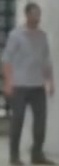

In [528]:
frame = cv2.imread(frame_loc)

d = display.display(None, display_id=True)
frame_disp = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(frame_disp))

In [529]:
with open(pose_loc, "r") as fp:
    raw_pose_data = json.load(fp)

pose = PoseKeypoints.load_keypoints(raw_pose_data["people"][0]["pose_keypoints_2d"])

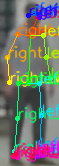

In [530]:
overlayed_frame = pose.overlay_pose(frame.copy())

d = display.display(None, display_id=True)
overlayed_frame_disp = cv2.cvtColor(overlayed_frame, cv2.COLOR_BGR2RGB) # Convert from CV2's BGR to RGB
d.update(Image.fromarray(overlayed_frame_disp))

In [531]:
pose.head_visibility_score()

1.0

In [532]:
pose.torso_arms_visibility_score()

1.0

In [533]:
pose.hip_visibility_score()

1.0

In [534]:
pose.legs_visibility_score()

1.0

In [535]:
pose.feet_visibility_score()

1.0

In [536]:
pose.sitting_ratios()

(0.9859609506163055, 0.9903765011469942)

In [537]:
pose.classify_general_pose()

'Full Body'

In [538]:
pose.is_sitting()

'Standing'

In [539]:
pose.classify()

'Full Body Standing'